In [129]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [130]:
df = pd.read_csv('loan.csv')
df.shape

(39717, 111)

In [131]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [132]:
# no duplicates 

df.id.nunique() , df.member_id.nunique()

(39717, 39717)

# Defining Target - 
- As given in dataset "loan_status" is the column which tells about past history of customer
- The customer who defaults will be given the value of 1 in the column "target" 

In [133]:
df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [134]:
# charged off implies default on loan 
d = { 
      'Fully Paid' : 0,
      'Current' : 0,
      'Charged Off' : 1
      }

df['target'] = df['loan_status'].map(d)

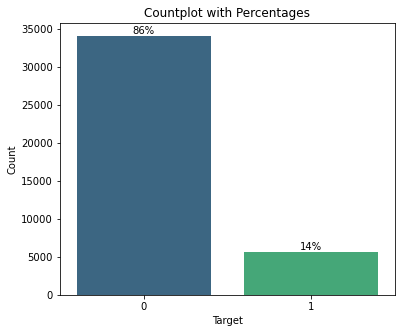

In [170]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='target', palette='viridis')

total = len(df['target'])
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Countplot with Percentages')
plt.show()

# Data Cleaning 

### Drop columns with no data

In [135]:
missing_df = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
missing_df.columns = ['columns' , 'missing_percentage']
missing_df= missing_df.sort_values('missing_percentage',ascending=False).reset_index(drop=True)

In [136]:
# get list of columns with 100 % null values and drop them from df

empty_columns = missing_df[missing_df['missing_percentage']==100]['columns'].to_list()

df.drop(columns = empty_columns , inplace=True)

missing_df = missing_df[(missing_df['missing_percentage']!=100)]

print(f'Number of columns remaining : {df.shape[1]}')

Number of columns remaining : 58


### Converting columns to appropriate data types

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [138]:
df['term']

0         36 months
1         60 months
2         36 months
3         36 months
4         60 months
            ...    
39712     36 months
39713     36 months
39714     36 months
39715     36 months
39716     36 months
Name: term, Length: 39717, dtype: object

In [139]:
# convert to str to int
df['term'] = [int(i[:3]) for i in df['term']]
df['term']

0        36
1        60
2        36
3        36
4        60
         ..
39712    36
39713    36
39714    36
39715    36
39716    36
Name: term, Length: 39717, dtype: int64

In [140]:
df['int_rate']

0        10.65%
1        15.27%
2        15.96%
3        13.49%
4        12.69%
          ...  
39712     8.07%
39713    10.28%
39714     8.07%
39715     7.43%
39716    13.75%
Name: int_rate, Length: 39717, dtype: object

In [141]:
# convert to str to int
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')
df['int_rate']

0        10.65
1        15.27
2        15.96
3        13.49
4        12.69
         ...  
39712     8.07
39713    10.28
39714     8.07
39715     7.43
39716    13.75
Name: int_rate, Length: 39717, dtype: float64

In [142]:
df['emp_length'].value_counts(dropna=False)

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
NaN          1075
Name: emp_length, dtype: int64

In [143]:
# fill na with 0 years employment 
df['emp_length'] = df['emp_length'].fillna(0)

# convert employment length column from str to int 
df['emp_length'] = df['emp_length'].astype(str).apply(lambda x : int(re.sub(r'\D','',x)))

df['emp_length'].value_counts()

10    8879
1     7823
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
0     1075
Name: emp_length, dtype: int64

In [144]:
# convert to str to int
df['revol_util'] = df['revol_util'].str.replace('%','').astype('float')

df['revol_util']

0        83.7
1         9.4
2        98.5
3        21.0
4        53.9
         ... 
39712    13.1
39713    26.9
39714    19.4
39715     0.7
39716    51.5
Name: revol_util, Length: 39717, dtype: float64

In [145]:
# convert to str to date 

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format='%b-%y')

df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'],format='%b-%y')

df['issue_d'] = pd.to_datetime(df['issue_d'],format='%b-%y')

df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'],format='%b-%y')

df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'],format='%b-%y')

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          39717 non-null  int64         
 1   member_id                   39717 non-null  int64         
 2   loan_amnt                   39717 non-null  int64         
 3   funded_amnt                 39717 non-null  int64         
 4   funded_amnt_inv             39717 non-null  float64       
 5   term                        39717 non-null  int64         
 6   int_rate                    39717 non-null  float64       
 7   installment                 39717 non-null  float64       
 8   grade                       39717 non-null  object        
 9   sub_grade                   39717 non-null  object        
 10  emp_title                   37258 non-null  object        
 11  emp_length                  39717 non-null  int64     

### Dropping redundant columns 

In [147]:
# all these columns have just one unique value and it does not provide any insights 
redundant_cols =  [
                  'pymnt_plan',
                  'initial_list_status',
                  'application_type',
                  'policy_code',
                  'tax_liens',
                  'chargeoff_within_12_mths',
                  'delinq_amnt',
                  'collections_12_mths_ex_med',
                  'acc_now_delinq'
                  ]

for i in redundant_cols:
   print(df[i].value_counts())
   print('========')

n    39717
Name: pymnt_plan, dtype: int64
f    39717
Name: initial_list_status, dtype: int64
INDIVIDUAL    39717
Name: application_type, dtype: int64
1    39717
Name: policy_code, dtype: int64
0.0    39678
Name: tax_liens, dtype: int64
0.0    39661
Name: chargeoff_within_12_mths, dtype: int64
0    39717
Name: delinq_amnt, dtype: int64
0.0    39661
Name: collections_12_mths_ex_med, dtype: int64
0    39717
Name: acc_now_delinq, dtype: int64


In [148]:
# drop emp_title as it does not give relevant insights after aggregation  

df['emp_title'].value_counts()

US Army                              134
Bank of America                      109
IBM                                   66
AT&T                                  59
Kaiser Permanente                     56
                                    ... 
Community College of Philadelphia      1
AMEC                                   1
lee county sheriff                     1
Bacon County Board of Education        1
Evergreen Center                       1
Name: emp_title, Length: 28820, dtype: int64

In [149]:
# drop url as it does not give any insights 

df['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=568534     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=567165     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568531     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=785667     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785630     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785626     1
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
Name: url, Length: 39717, dtype: int64

In [150]:
drop_cols = [
             'pymnt_plan',
             'initial_list_status',
             'application_type',
             'policy_code',
             'tax_liens',
             'chargeoff_within_12_mths',
             'delinq_amnt',
             'collections_12_mths_ex_med',
             'acc_now_delinq',
             'url',
             'emp_title',
             'zip_code',
             'id',
             'member_id',
             'desc'
             ]
df.drop(columns=drop_cols , inplace=True)

missing_df = missing_df[~missing_df['columns'].isin(drop_cols)].reset_index(drop=True)

- let's check how many columns have missing value now 

<AxesSubplot:xlabel='missing_percentage', ylabel='columns'>

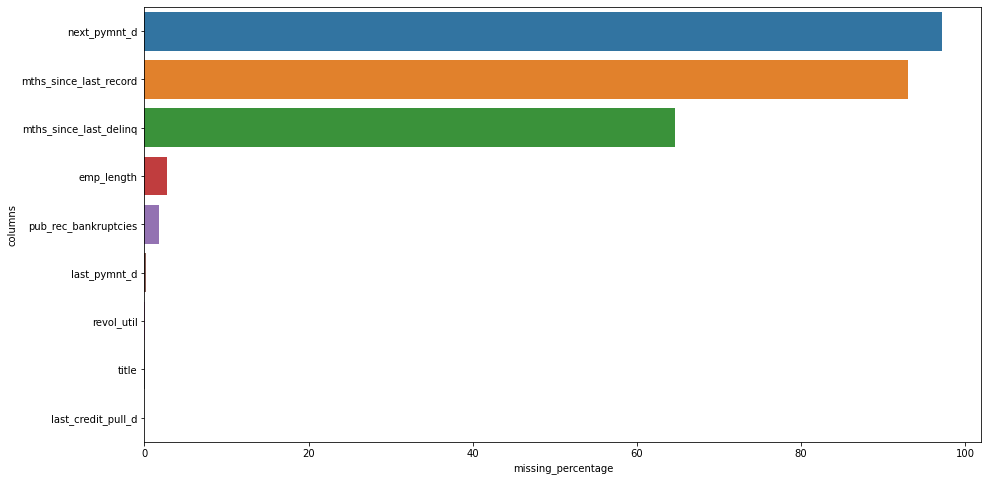

In [161]:
fig = plt.figure(figsize=(15,8))

missing_df = missing_df[missing_df['missing_percentage']!=0]

sns.barplot(data=missing_df,y=missing_df['columns'],x=missing_df['missing_percentage'])

### Check Distribution 

In [151]:
numeric_cols = df.select_dtypes(include=['int','float']).columns.to_list()
obj_cols = df.select_dtypes(include=['object']).columns.to_list()

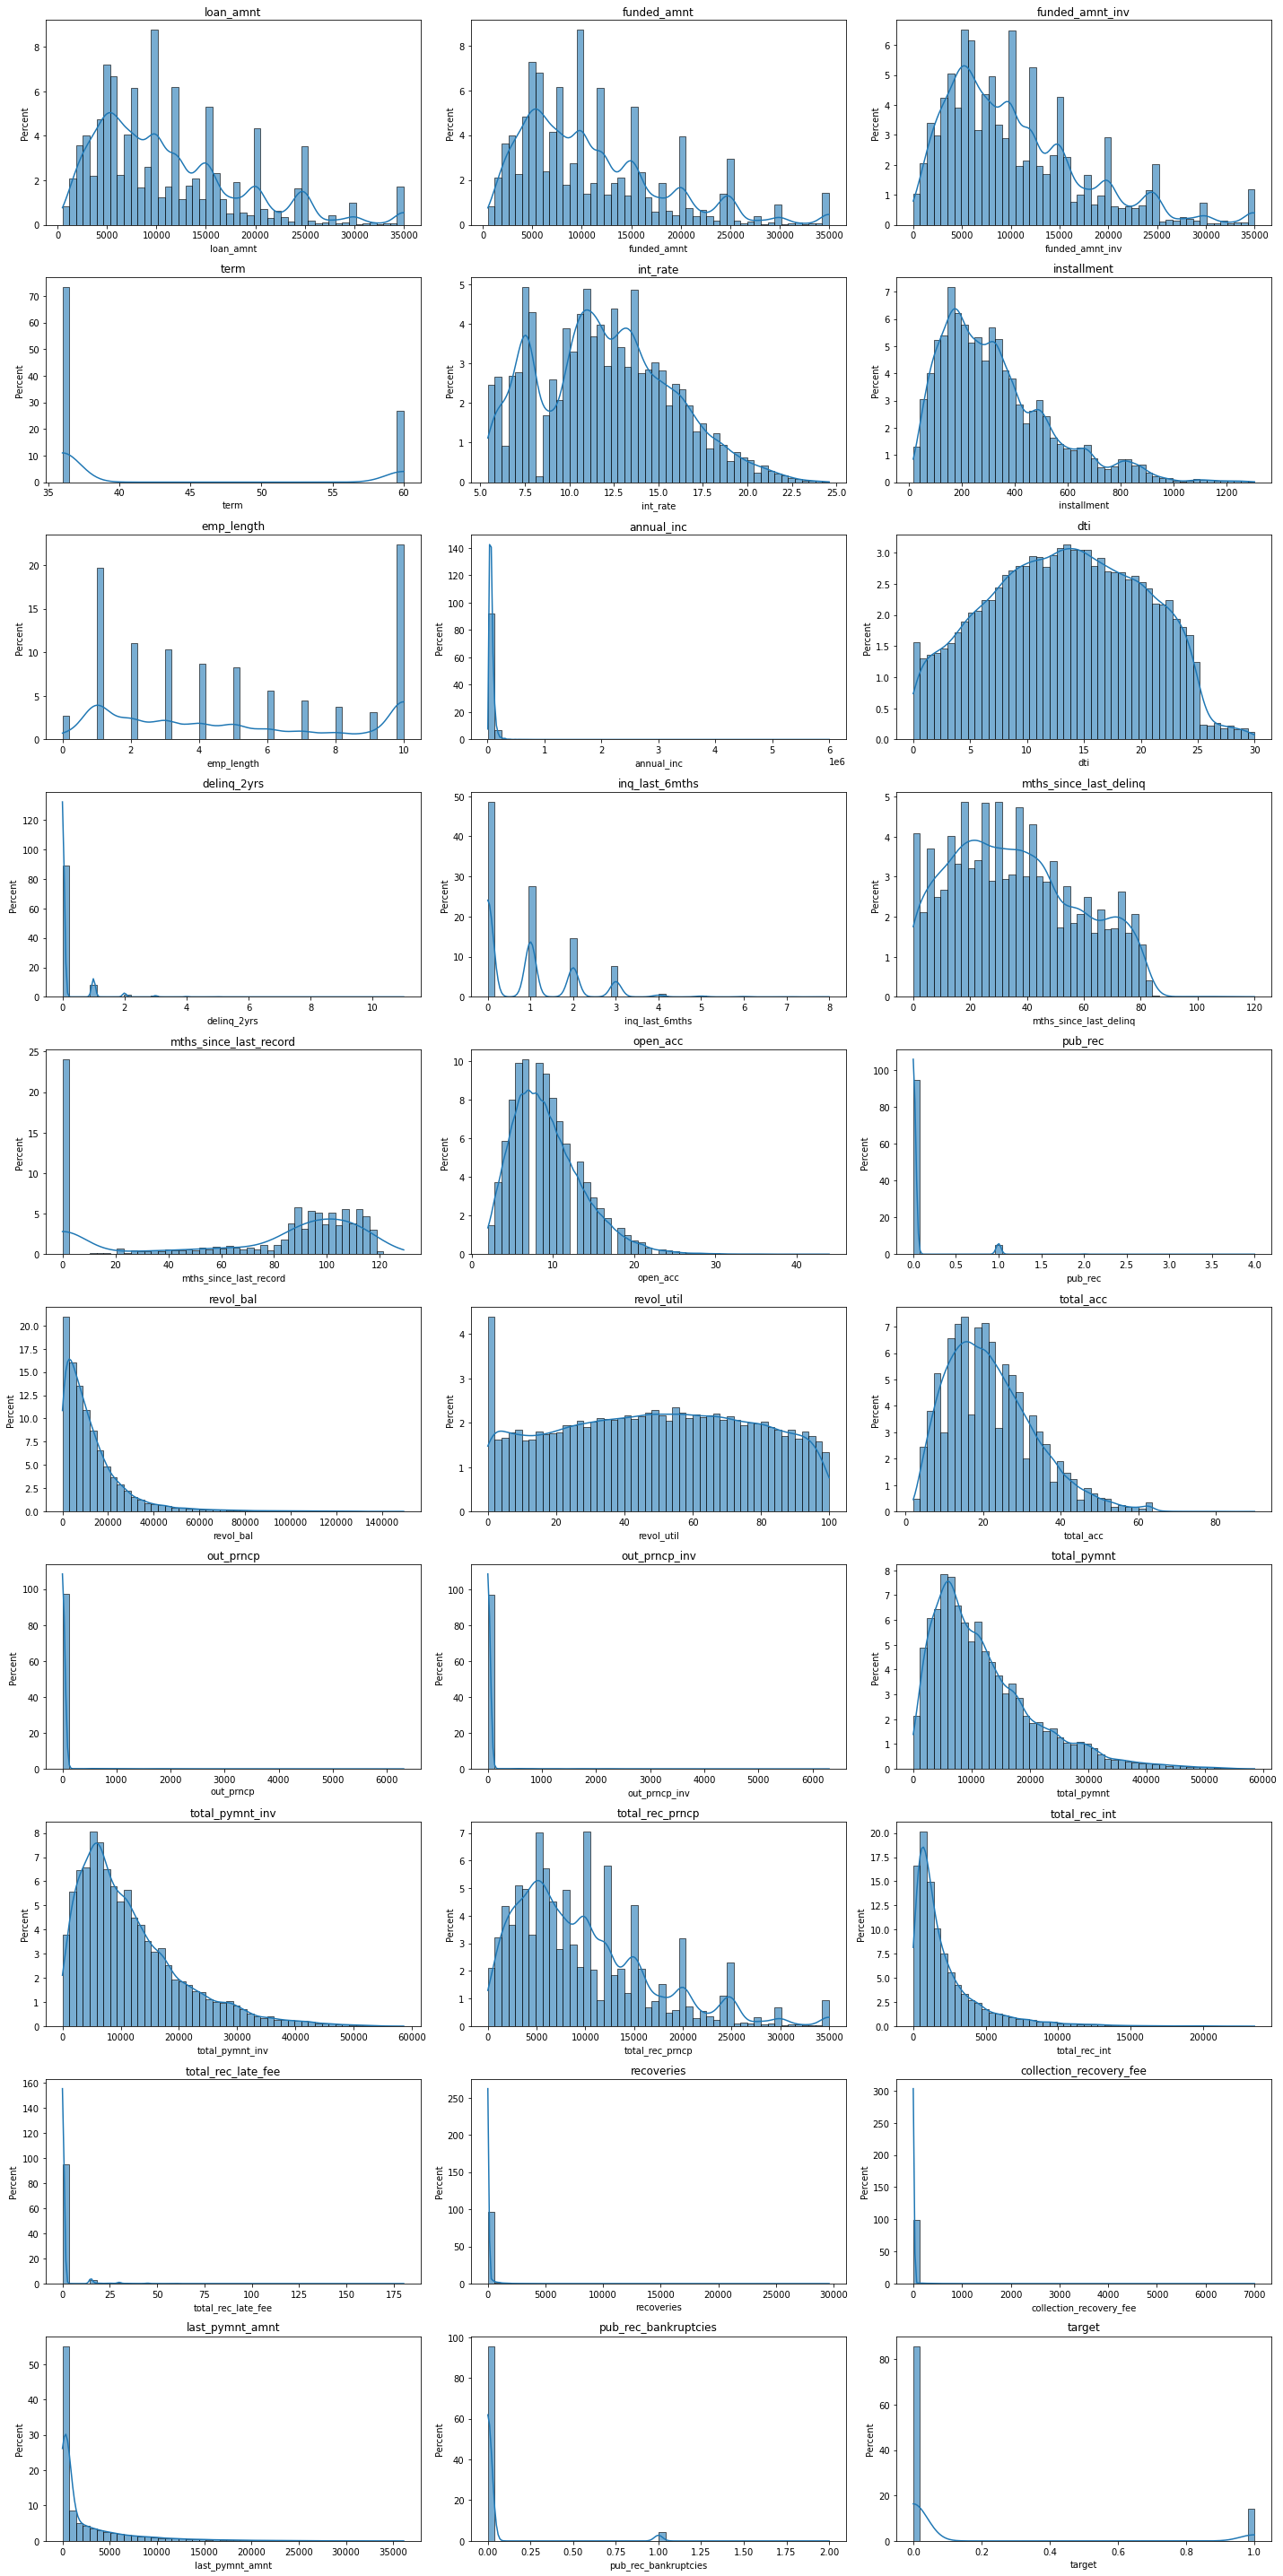

In [103]:

n_bins = 50
palette = sns.color_palette("pastel") 

columns = numeric_cols
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
ax = ax.flatten()

for i, column in enumerate(columns):
   sns.histplot(
      df[column], kde=True, stat='percent', bins=n_bins,
      ax=ax[i], alpha=0.6
   )
   ax[i].set_title(column)  # title for each subplot

plt.tight_layout()
plt.show()

- ##### from histogram we can see that outliers present in "annual_inc"

In [104]:
outliers = np.percentile(df['annual_inc'] , 95)
df = df[df['annual_inc']<=outliers]

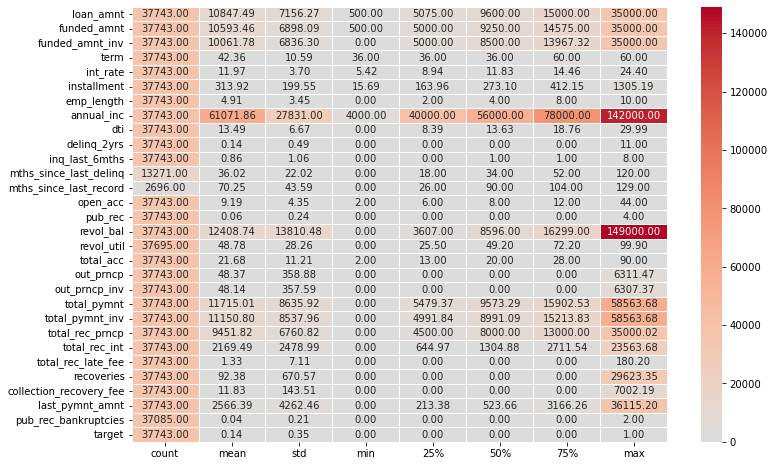

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

sns.heatmap(df.describe().T, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

plt.xticks(ticks=plt.xticks()[0], labels=df.describe().T.columns)

plt.show()